In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_9_descriptive = get_prompt("descriptive", 9)
prompt_9_natural = get_prompt("natural", 9)

prompt_9_descriptive, prompt_9_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area). 8. Simulate for 1ps at 400K. 9. Compute the RMSD of the 400K simulation.',
 'Simulate 1LYZ for 1ps at 300 K and for 1ps at 400K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute SASA and radius of gyration of the 300K simulation. Compute RMSD of both simulations.')

In [3]:
llm_model = "claude-3-5-sonnet-20241022"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_9_descriptive)

Thought: Let's solve this step by step. First, let's download the PDB file 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that we have downloaded the PDB file, let's analyze its secondary structure using DSSP.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_205655",
        "top_file": "1LYZ_205655",
        "target_frames": "all"
    }
}
```

Thought: Let's continue with finding the binding and active sites for lysozyme (1LYZ). First, we need to get its UniProt ID.

Action:
```
{
    "action": "GetUniprotID",
    "action_input": "1LYZ"
}
```

Thought: Let's continue by getting all known sites for lysozyme using the UniProt ID we just obtained.

Action:
```
{
    "action": "GetAllKnownSites",
    "action_input": {
        "query": "P17897",
        "primary_accession": "P17897"
    }
}
```

Thought: Now let's set up and run a 1ps simulation at 300K. We'

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_205655: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_205655
 rec0_205657: dssp values for trajectory with id: 1LYZ_205655
 1LYZ_205718: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_205722: Initial positions for simulation sim0_205722
 sim0_205722: Basic Simulation of Protein 1LYZ_205718
 rec0_205731: Simulation trajectory for protein 1LYZ_205718 and simulation sim0_205722
 rec1_205731: Simulation state log for protein 1LYZ_205718 and simulation sim0_205722
 rec2_205731: Simulation pdb frames for protein 1LYZ_205718 and simulation sim0_205722
 rmsd_205722: RMSD for 205722
 fig0_210325: RMSD plot for 205722
 rgy_rec0_205731: Radii of gyration per frame for rec0_205731
 fig0_210328: Plot of radii of gyration over time for rec0_205731
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_211244: Plot of SASA over time for 1LYZ
 top_si

In [7]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_205655"))

In [8]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_205655", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [9]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P17897")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [12]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("rec0_205731")
top_path_1_1 = registry_1.get_mapped_path("top_sim0_205722")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

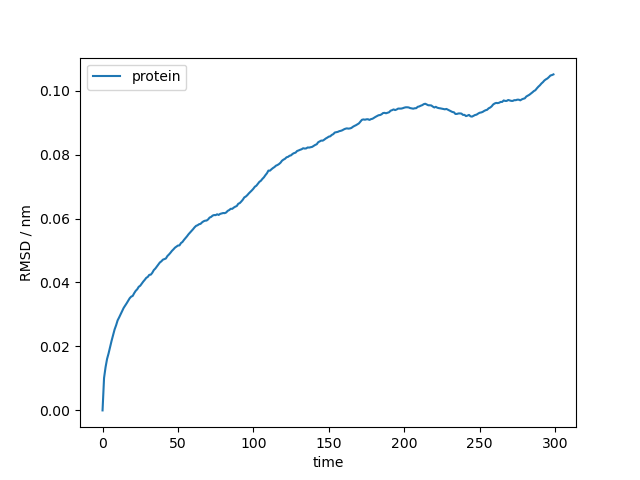

In [13]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_210325'))

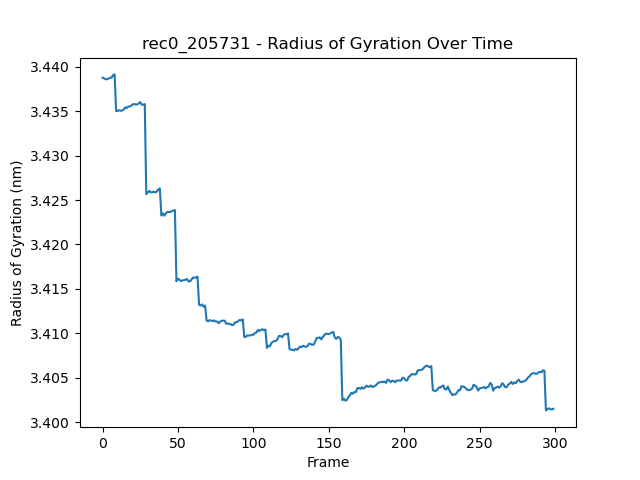

In [14]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_210328'))

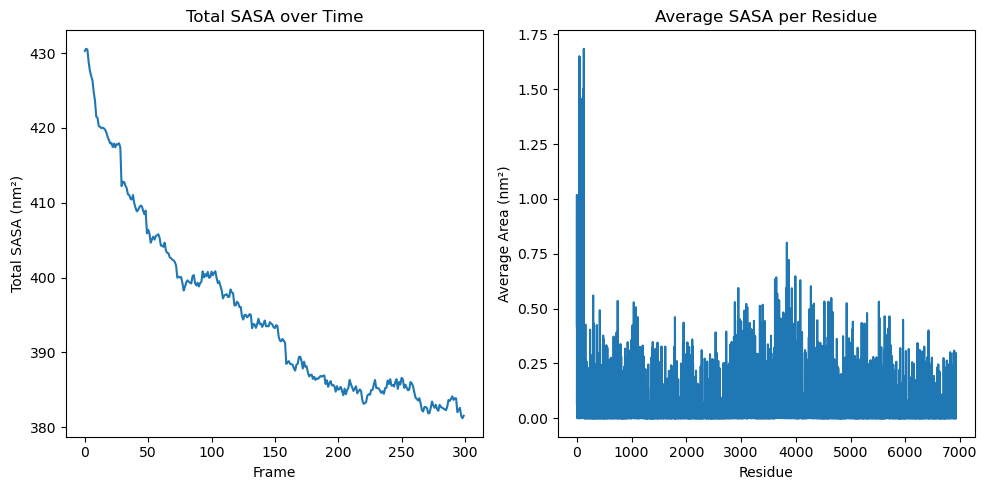

In [15]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_211244'))

In [16]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("rec0_211257")
top_path_1_2 = registry_1.get_mapped_path("top_sim0_211250")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

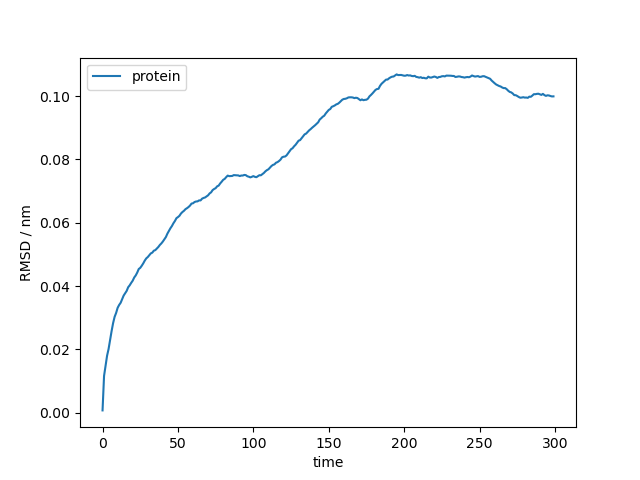

In [17]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_211817'))

In [18]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_9_natural)

Thought: I'll break this down into steps: 1) Download 1LYZ, 2) Get binding/active sites info, 3) Run simulations at both temperatures, 4) Analyze secondary structure, 5) Calculate SASA and Rg for 300K sim, 6) Calculate RMSD for both sims. Let's start by downloading 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that we have the PDB file, let's get information about binding and active sites before proceeding with simulations.

Action:
```
{
    "action": "GetAllKnownSites",
    "action_input": {
        "query": "1LYZ",
        "primary_accession": "P00698"
    }
}
```

Thought: Let's analyze the secondary structure of the downloaded PDB structure before running simulations.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_212952",
        "top_file": "1LYZ_212952",
        "target_frames": "first"
    }
}
```

Thought: Now let's run the first simulation 

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [19]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_212952: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_212952
 rec0_212959: dssp values for trajectory with id: 1LYZ_212952
 1LYZ_213010: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_213015: Initial positions for simulation sim0_213015
 sim0_213015: Basic Simulation of Protein 1LYZ_213010
 rec0_213019: Simulation trajectory for protein 1LYZ_213010 and simulation sim0_213015
 rec1_213019: Simulation state log for protein 1LYZ_213010 and simulation sim0_213015
 rec2_213019: Simulation pdb frames for protein 1LYZ_213010 and simulation sim0_213015
 top_sim0_213503: Initial positions for simulation sim0_213503
 sim0_213503: Basic Simulation of Protein 1LYZ_213010
 rec0_213507: Simulation trajectory for protein 1LYZ_213010 and simulation sim0_213503
 rec1_213507: Simulation state log for protein 1LYZ_213010 and simulation sim0_21

In [20]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_212952"))

In [21]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_212952", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [22]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [29]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("rec0_213019")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_213015")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

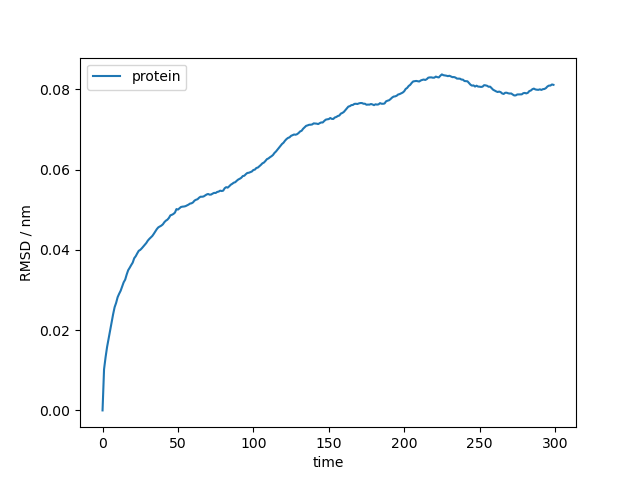

In [28]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_214938'))

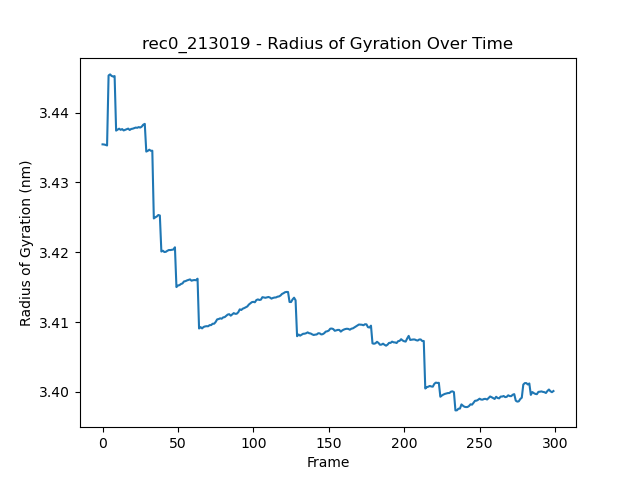

In [27]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_214934'))

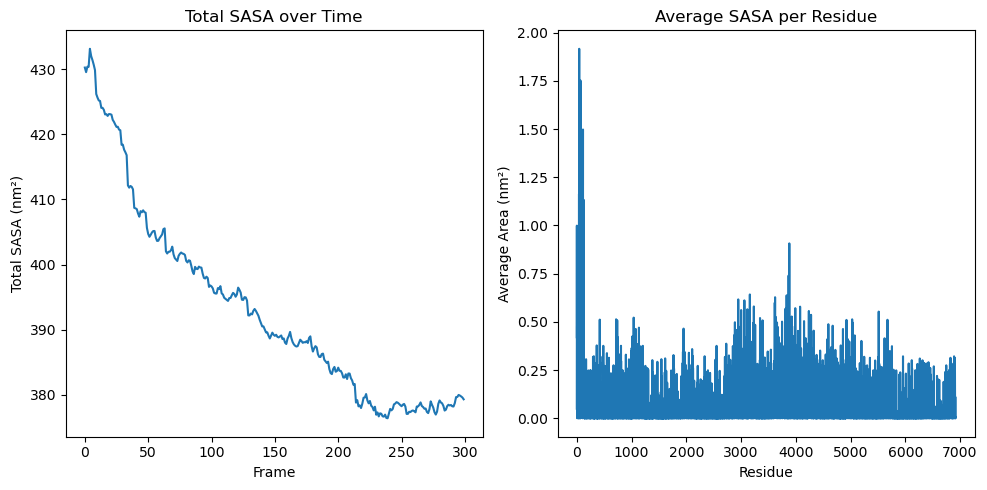

In [26]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_214930'))

In [25]:
# make sure trajectory and topology exist (sim1)
traj_path_2_2 = registry_2.get_mapped_path("rec0_213507")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_213503")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)

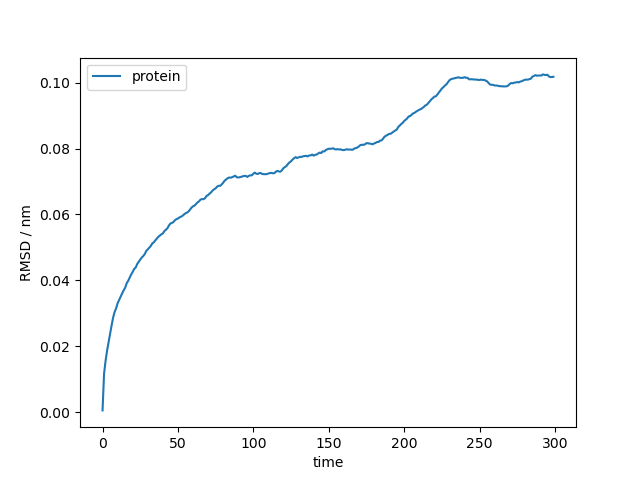

In [24]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_214941'))